In [ ]:
#PyTorch 

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
# from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

#pandas, numpy
import pandas as pd
import numpy as np

## helpers
from pandas.api.types import is_numeric_dtype
from operator import floordiv

#graphs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers
    return d

def get_dates_variable(df):
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
    df['Hour'] = df['pickup_date'].dt.hour
    df['AM'] = np.where(df['Hour']<12,'AM','PM')
    df['Weekday'] = df['pickup_date'].dt.strftime("%a")
    return df.drop(['pickup_date', 'pickup_datetime'], axis=1)

def embedded_init_weight(x):
    x = x.weight.data
    sc = 2.0 / (x.size(1)+1.0)
    x.uniform_(-sc,sc)

In [3]:
### data

df_train = pd.read_csv("taxidataset/train_10k.csv")
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df_train = df_train.loc[df_train.fare_amount > 0]
# df_test = df_test.loc[df_test.fare_amount > 0]
df_train.fare_amount.min()

0.01

## Preprocessing

In [6]:
df_train_pp = get_dates_variable(df_train)

lst_categorical = [ 'Hour', 'AM', 'Weekday']
lst_float = [ 'pickup_longitude' , 'pickup_latitude'
            , 'dropoff_longitude', 'dropoff_latitude'
            ]
lst_integer =[ 'passenger_count']
y_name = 'fare_amount'

lst_numeric = lst_float + lst_integer

df_train_pp[lst_categorical] = df_train_pp[lst_categorical].astype("category")

## Get number of input/output for embbeded layers
lst_embbeded_size = [( df_train_pp[col].cat.categories.size
                    , floordiv(df_train_pp[col].cat.categories.size + 1, 2)
                    ) for col in lst_categorical
                   ]

identity = FunctionTransformer(lambda x: x)

preprocessor = ColumnTransformer(
                transformers=[
                      ('cat', OrdinalEncoder(), selector(dtype_include="category"))
                    , ('num', StandardScaler(), selector(dtype_include="float"))
                    , ('int', identity, selector(dtype_include="int"))
                ]
                )

preprocessor.fit(df_train_pp)
df_train_np = preprocessor.transform(df_train_pp)

df_train_pp = pd.DataFrame(df_train_np, columns=lst_categorical + lst_float + lst_integer + [y_name])

## Data model

In [8]:
class TabularData(data.Dataset):
    def __init__(self, X, y, lst_categorical, lst_numeric, device):
        # super().__init__()
        self.x_categorical = torch.from_numpy(X[lst_categorical].astype("int64").to_numpy()).to(device)
        self.x_numeric = torch.from_numpy(X[lst_numeric].to_numpy()).to(device)
        self.y = torch.from_numpy(y.to_numpy()).to(device)
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return [self.x_categorical[index], self.x_numeric[index], self.y[index]]

## Neural Network

In [10]:
class Autoencoder(nn.Module):
    "Tabular AE"
    def __init__(self, Layers, n_numeric, lst_embbeded_size):
        super(Autoencoder, self).__init__()
        self.out_dim = 1
        self.n_num = n_numeric
        
        self.layers = nn.ModuleList()
        self.embbeded = nn.ModuleList([nn.Embedding( num_embeddings=input_size
                                                   , embedding_dim=output_size
                                                   ) 
                                        for input_size, output_size in lst_embbeded_size
                                      ])
        
        ## weight initialization for embedded layers
        self.n_emb = 0
        for emb in self.embbeded:
            embedded_init_weight(emb)
            self.n_emb += emb.embedding_dim

        ## add additional layer for concatanated layer
        total_layers =  [self.n_emb + self.n_num] + Layers

        ## batchnorm for first numeric layer
        self.bn_numeric = nn.BatchNorm1d(self.n_num)

        ## dropout layer for first embedded layer
        self.embbeded_dropout = nn.Dropout(0.1)

        ## list of internal layers
        self.dropout = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        for input_size, output_size in zip(total_layers, total_layers[1:]):
            self.dropout.append(nn.Dropout(0.01))
            self.linear_layers.append(nn.Linear(input_size, output_size))
            self.bn_layers.append(nn.BatchNorm1d(output_size))
                                  
        ## final layer
        self.final_ll = nn.Linear(total_layers[-1], self.out_dim)
        
        ## weight initialization for linear layers
        for ll in self.linear_layers:
            nn.init.kaiming_normal_(ll.weight.data)
        nn.init.kaiming_normal_(self.final_ll.weight.data)

    def forward(self, x_categorical, x_numeric):
        ## create embeddeds for each categorical
        x_cat = [ embedded_layer(x_categorical[:,i])
                    for i, embedded_layer in enumerate(self.embbeded)
                ]
        ## concat embedded layers and normalize with dropout
        x_cat  = torch.concat(x_cat, 1)
        x_cat = self.embbeded_dropout(x_cat)

        ## apply first batchnormalization to numeric layer
        x_num = self.bn_numeric(x_numeric)

        ## concat both embedded anb numeric
        x = torch.concat([x_cat, x_num], 1)
        
        for ll, bn, do in zip( self.linear_layers
                             , self.bn_layers
                             , self.dropout
                             ):
            x = ll(x)
            x = F.relu(x)
            x = bn(x)
            x = do(x)

        x = self.final_ll(x)
        return x.squeeze()

## Data preparation before model

In [12]:
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train, X_validation, y_train, y_validation = train_test_split( df_train_pp.drop([y_name],axis=1)
                                                               , df_train_pp[y_name]
                                                               , test_size=0.20
                                                               , random_state=42
                                                               , shuffle=True
                                                               ) 

data_tabular_train      = TabularData(X_train, y_train, lst_categorical, lst_numeric, device)
data_tabular_validation = TabularData(X_validation, y_validation, lst_categorical, lst_numeric, device)

dataloader_tabular_train      = data.DataLoader(data_tabular_train, batch_size=128, shuffle=True)
dataloader_tabular_validation = data.DataLoader(data_tabular_validation, batch_size=128, shuffle=True)

In [13]:
X_train.head()

,Hour,AM,Weekday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
6715,16.0,1.0,0.0,-0.077044,-0.140050,0.117193,-0.140950,0.143569
1561,20.0,1.0,4.0,-0.077044,6.829503,-5.453841,6.849570,-6.291744
1670,19.0,1.0,5.0,-0.181393,-0.143960,0.110299,-0.143753,0.135437
4345,4.0,0.0,5.0,0.507313,-0.123497,0.099069,-0.130567,0.123169
8098,20.0,1.0,2.0,-0.577921,-0.144999,0.109605,-0.144074,0.130486


In [14]:
data_tabular_train[0]

[tensor([16,  1,  0], device='cuda:0'),
 tensor([-0.0770, -0.1401,  0.1172, -0.1409,  0.1436], device='cuda:0',
        dtype=torch.float64),
 tensor(1., device='cuda:0', dtype=torch.float64)]

In [15]:
lst_embbeded_size

[(24, 12), (2, 1), (7, 4)]

### model training parameters

In [17]:
Layers = [16, 8, 4]
model = Autoencoder( Layers=Layers
                   , n_numeric=len(lst_numeric)
                   , lst_embbeded_size=lst_embbeded_size
                   )

epochs = 50
learning_rate = 1e-2
optimizer = optim.Adam(model.parameters(), learning_rate)
# lr_cosine = lr_scheduler.CosineAnnealingLR(optimizer, 1000)
criterion = torch.nn.MSELoss()

In [18]:
LOSS = []
model.to(device, dtype=torch.float64)
model.train()
for epoch in range(epochs):
    for x_cat, x_num, y in dataloader_tabular_train:
        optimizer.zero_grad()
        yhat = model(x_cat, x_num)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        LOSS.append(loss.item())

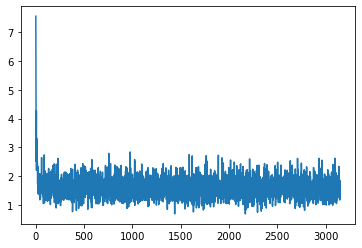

In [19]:
plt.plot(LOSS)
plt.show()